# Problem
The goal of this project is to develop a recommender system that provides personalized book recommendations to users based on their past reading behavior. The system should be able to suggest new books to users that they are likely to enjoy, based on their previous reading history and preferences.

# Data Collection
The data for this project was sourced from Book Recommendation Dataset on Kaggle by MÖBIUS.
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn

import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.nn import functional as F

from BookDataset import BookDataset # jupyter notebook has issue of calling the dataset class in the same file with model

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

# Data Preprocessing

In [3]:
rating = pd.read_csv("Ratings.csv")
rating.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
books = pd.read_csv("Books.csv")
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
users = pd.read_csv("Users.csv")
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
print(rating.isnull().sum())
print("-"*50)
print(books.isnull().sum())
print("-"*50)
print(users.isnull().sum())
print("-"*50)

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
--------------------------------------------------
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64
--------------------------------------------------
User-ID          0
Location         0
Age         110762
dtype: int64
--------------------------------------------------


In [7]:
books_data=books.merge(rating,on="ISBN")
print(rating.shape,books_data.shape)
books_data.head()

(1149780, 3) (1031136, 10)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [8]:
books_data.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            4
User-ID                0
Book-Rating            0
dtype: int64

In [9]:
df=books_data.copy()
# drop nan
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

# drop unuse features
df.drop(columns=["ISBN","Year-Of-Publication","Image-URL-S","Image-URL-M"],axis=1,inplace=True)

# drop no rating
df.drop(index=df[df["Book-Rating"]==0].index, inplace=True)

df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
df.head()

,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8,5
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11676,8
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,67544,8
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,116866,9
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,123629,9


In [10]:
df.shape

(383838, 6)

In [11]:
df["User-ID"].nunique()

68091

In [12]:
df["Book-Title"].nunique()

134550

Observation: 

Since there is a significant difference in the number of users and books, adjusting the embedding size for books may improve the model's ability to capture the important features of books.

# Datasets / Data Loader

In [13]:
# # jupyter notebook has issue of calling the dataset class in the same file with model
# class BookDataset(Dataset):
#     def __init__(self, users, books, ratings):
#         self.users = users
#         self.books = books
#         self.ratings = ratings

#         # encode user and book ids to start from 0
#         self.lbl_user = preprocessing.LabelEncoder()
#         self.lbl_book = preprocessing.LabelEncoder()
#         self.users = self.lbl_user.fit_transform(users)
#         self.books = self.lbl_book.fit_transform(books)

#     def __len__(self):
#         return len(self.users)

#     def __getitem__(self, idx):
#         user = self.users[idx]
#         book = self.books[idx]
#         rating = self.ratings[idx]
#         return {"users":  torch.tensor(user, dtype=torch.long), 
#                 "books": torch.tensor(book, dtype=torch.long), 
#                 "ratings": torch.tensor(rating, dtype=torch.float)}



In [14]:
df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.25, random_state=42, stratify=df["Book-Rating"].values
)
df_test, df_valid = model_selection.train_test_split(
    df_valid, test_size=0.5, random_state=42, stratify=df_valid["Book-Rating"].values
)

train_dataset = BookDataset(
    users=df_train["User-ID"].values,
    books=df_train["Book-Title"].values,
    ratings=df_train["Book-Rating"].values
)

valid_dataset = BookDataset(
    users=df_valid["User-ID"].values,
    books=df_valid["Book-Title"].values,
    ratings=df_valid["Book-Rating"].values
)

test_dataset = BookDataset(
    users=df_test["User-ID"].values,
    books=df_test["Book-Title"].values,
    ratings=df_test["Book-Rating"].values
)


In [15]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

val_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

dataiter = iter(train_loader)
dataloader_data = next(dataiter)
print(dataloader_data)

{'users': tensor([27397, 34152, 13285,  1508, 15106, 35664, 17725, 50905, 23384, 24475,
        20384, 32043, 25808, 19362,  6654, 20384, 49883, 33114, 50745, 10331,
        56468, 12678, 48575, 10689,  4081, 52702, 32306, 13263, 28731, 57387,
        18692, 51707]), 'books': tensor([ 26624,  13932,  86411,  69066,  49827,  77447, 104366,  88557, 102651,
         25412,  84038,  55112,  66510,   6734,  20276,  84570,    427,  65096,
          6734,  43965,  57613,  42519,  14274,  14123,  22315,  95103,  99896,
         58053,  71340,   1960,  89539, 103652]), 'ratings': tensor([10.,  8.,  6.,  6.,  8.,  7., 10., 10.,  6.,  8.,  9.,  9., 10.,  9.,
         8.,  9., 10., 10., 10.,  8.,  4.,  7.,  8.,  8.,  5.,  9.,  7.,  8.,
         5.,  9.,  8.,  9.])}


# Model

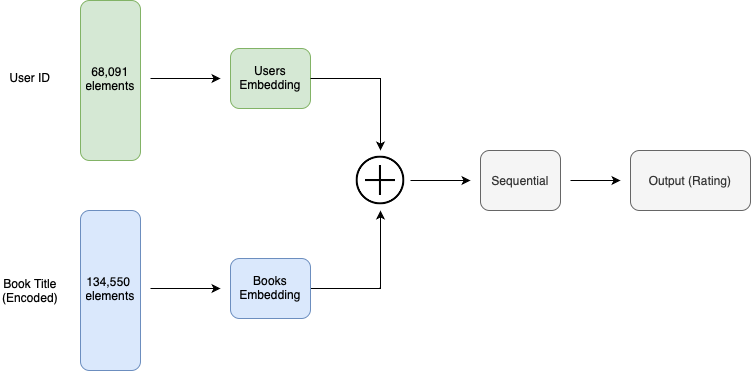

In [16]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_books, user_embedding_size=128, book_embedding_size=384, dropout_rate=0.5):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(n_users, user_embedding_size)
        self.book_embed = nn.Embedding(n_books, book_embedding_size)
        # user, movie embedding concat
        self.dropout = nn.Dropout(p=dropout_rate)
        self.layers = nn.Sequential(
            nn.Linear(user_embedding_size + book_embedding_size, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, users, books):
        user_embeds = self.user_embed(users)
        book_embeds = self.book_embed(books)
        x = torch.cat([user_embeds, book_embeds], dim=1)
        x = self.dropout(x)
        x = self.layers(x)
        
        return x


In [17]:
model = RecSysModel(
    n_users=df["User-ID"].nunique(),
    n_books=df["Book-Title"].nunique(),
).to(device)
model

RecSysModel(
  (user_embed): Embedding(68091, 128)
  (book_embed): Embedding(134550, 384)
  (dropout): Dropout(p=0.5, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Train

In [18]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10, patient=3):
    best_loss = float('inf')
    counter = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        train_loss, train_acc = TrainEpoch(model, loss_fn, optimizer, train_loader)
        val_loss, val_acc = EvalModel(model, loss_fn, val_loader)
        print("Train Loss : {:.3f} | Train RMSE : {:.3f} " .format(train_loss, train_acc)) 
        print("Valid Loss : {:.3f} | Valid RMSE : {:.3f} " .format(val_loss, val_acc))
        print(f"Current Learning Rate : {optimizer.param_groups[0]['lr']:.7f}")
        print("-"*80)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if val_loss <= best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            print(f"Current Counter is {counter}/{patient}")
            
        if counter == patient:
            break
        
        scheduler.step(val_loss) # update learning rate after each epoch
    
    return train_losses, train_accs, val_losses, val_accs


def TrainEpoch(model, loss_fn, optimizer, train_loader):
    model.train()
    total_loss = 0 
    total_samples = 0
    
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        users = batch["users"].to(device)
        books = batch["books"].to(device)
        ratings = batch["ratings"].to(device)
        
        output = model(users, books)
        rating = ratings.view(ratings.shape[0], -1).to(torch.float32)
        loss = loss_fn(output, rating)
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.sum().item()
        total_samples += rating.shape[0]
    
    train_loss = total_loss/total_samples
    train_rmse = torch.sqrt(torch.tensor(train_loss))

    return train_loss, train_rmse


def EvalModel(model, loss_fn, val_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0 
        total_samples = 0
        
        for batch in tqdm(val_loader):
            users = batch["users"].to(device)
            books = batch["books"].to(device)
            ratings = batch["ratings"].to(device)
        
            output = model(users, books)
            rating = ratings.view(ratings.shape[0], -1).to(torch.float32)
            loss = loss_fn(output, rating)
            
            total_loss = total_loss + loss.sum().item()
            total_samples += rating.shape[0]
        
        val_loss = total_loss/total_samples
        val_rmse = torch.sqrt(torch.tensor(val_loss))
        
        return val_loss, val_rmse


In [19]:
epochs = 30
initail_lr = 0.001 
optimizer = torch.optim.Adam(model.parameters(), lr = initail_lr)  
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=True)
loss_fn = nn.MSELoss()

train_losses, train_rmse, val_losses, val_rmse = TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs, patient=5)

Epoch 0


100%|███████████████████████████████████████| 1500/1500 [00:16<00:00, 91.64it/s]


Train Loss : 0.153 | Train RMSE : 0.391 
Valid Loss : 0.116 | Valid RMSE : 0.341 
Current Learning Rate : 0.0010000
--------------------------------------------------------------------------------
Epoch 1


100%|███████████████████████████████████████| 1500/1500 [00:17<00:00, 87.00it/s]


Train Loss : 0.103 | Train RMSE : 0.322 
Valid Loss : 0.112 | Valid RMSE : 0.334 
Current Learning Rate : 0.0010000
--------------------------------------------------------------------------------
Epoch 2


100%|███████████████████████████████████████| 1500/1500 [00:17<00:00, 87.98it/s]


Train Loss : 0.090 | Train RMSE : 0.300 
Valid Loss : 0.113 | Valid RMSE : 0.336 
Current Learning Rate : 0.0010000
--------------------------------------------------------------------------------
Current Counter is 1/5
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.
Epoch 3


100%|███████████████████████████████████████| 1500/1500 [00:17<00:00, 86.46it/s]


Train Loss : 0.084 | Train RMSE : 0.289 
Valid Loss : 0.114 | Valid RMSE : 0.338 
Current Learning Rate : 0.0001000
--------------------------------------------------------------------------------
Current Counter is 2/5
Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.
Epoch 4


100%|███████████████████████████████████████| 1500/1500 [00:17<00:00, 84.87it/s]


Train Loss : 0.083 | Train RMSE : 0.287 
Valid Loss : 0.114 | Valid RMSE : 0.338 
Current Learning Rate : 0.0000100
--------------------------------------------------------------------------------
Current Counter is 3/5
Epoch 00005: reducing learning rate of group 0 to 1.0000e-06.
Epoch 5


100%|███████████████████████████████████████| 1500/1500 [00:16<00:00, 88.71it/s]


Train Loss : 0.082 | Train RMSE : 0.287 
Valid Loss : 0.114 | Valid RMSE : 0.338 
Current Learning Rate : 0.0000010
--------------------------------------------------------------------------------
Current Counter is 4/5
Epoch 00006: reducing learning rate of group 0 to 1.0000e-07.
Epoch 6


100%|███████████████████████████████████████| 1500/1500 [00:17<00:00, 86.72it/s]

Train Loss : 0.083 | Train RMSE : 0.287 
Valid Loss : 0.114 | Valid RMSE : 0.338 
Current Learning Rate : 0.0000001
--------------------------------------------------------------------------------
Current Counter is 5/5


# Evaluation

In [20]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)

with torch.no_grad():
    for i, batched_data in enumerate(test_loader): 
        users = batched_data['users'].to(device)
        books = batched_data['books'].to(device)
        ratings = batched_data['ratings'].to(device)
        
        model_output = model(batched_data['users'].to(device), batched_data["books"].to(device))

        for j in range(len(users)):
            user_id = users[j].item()
            book_id = books[j].item() 
            pred_rating = model_output[j][0].item()
            true_rating = ratings[j].item()

            user_est_true[user_id].append((pred_rating, true_rating))
            if user_id % 1000 == 0:
                print(f"{user_id}, {book_id}, {pred_rating}, {true_rating}")



9000, 18584, 7.388184547424316, 10.0
7000, 24792, 7.006982803344727, 7.0
1000, 27756, 7.205108642578125, 7.0
9000, 6066, 7.392521858215332, 10.0
13000, 25323, 7.155637264251709, 8.0
7000, 4946, 7.050224304199219, 6.0
9000, 20962, 7.478093147277832, 10.0
4000, 22183, 7.522426128387451, 7.0
8000, 9508, 7.4827094078063965, 9.0
15000, 16769, 8.080557823181152, 7.0
6000, 11175, 6.387195587158203, 7.0
13000, 6211, 7.331489562988281, 7.0
3000, 6401, 6.996507167816162, 7.0
9000, 6358, 7.534978866577148, 9.0
10000, 9135, 7.348501682281494, 8.0
17000, 29257, 7.703776836395264, 5.0
8000, 23373, 7.423989772796631, 7.0
11000, 3158, 7.146066665649414, 7.0
9000, 27983, 7.509339332580566, 6.0
9000, 7215, 7.5515336990356445, 8.0
8000, 15001, 7.422738075256348, 8.0
10000, 14586, 7.470322608947754, 7.0
19000, 24054, 7.314009666442871, 7.0
5000, 25290, 7.833146095275879, 7.0
16000, 19542, 6.980412483215332, 9.0
0, 8477, 7.177332401275635, 6.0
12000, 3454, 7.559459209442139, 7.0
9000, 7674, 7.2150897979736

In [21]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k=10
    threshold= 7

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # 这里 get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # 这里 get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # 这里 get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        if uid % 500 == 0:
            print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

uid 8500,  n_rel 1, n_rec_k 1, n_rel_and_rec_k 1
uid 11500,  n_rel 1, n_rec_k 1, n_rel_and_rec_k 1
uid 9000,  n_rel 11, n_rec_k 10, n_rel_and_rec_k 9
uid 18500,  n_rel 0, n_rec_k 1, n_rel_and_rec_k 0
uid 7000,  n_rel 2, n_rec_k 3, n_rel_and_rec_k 2
uid 1000,  n_rel 1, n_rec_k 1, n_rel_and_rec_k 1
uid 6500,  n_rel 0, n_rec_k 1, n_rel_and_rec_k 0
uid 13000,  n_rel 2, n_rec_k 2, n_rel_and_rec_k 2
uid 4500,  n_rel 2, n_rec_k 4, n_rel_and_rec_k 2
uid 2500,  n_rel 16, n_rec_k 10, n_rel_and_rec_k 10
uid 4000,  n_rel 1, n_rec_k 1, n_rel_and_rec_k 1
uid 8000,  n_rel 3, n_rec_k 3, n_rel_and_rec_k 3
uid 15000,  n_rel 1, n_rec_k 1, n_rel_and_rec_k 1
uid 16500,  n_rel 1, n_rec_k 0, n_rel_and_rec_k 0
uid 6000,  n_rel 1, n_rec_k 0, n_rel_and_rec_k 0
uid 3500,  n_rel 0, n_rec_k 1, n_rel_and_rec_k 0
uid 13500,  n_rel 1, n_rec_k 1, n_rel_and_rec_k 1
uid 7500,  n_rel 2, n_rec_k 3, n_rel_and_rec_k 2
uid 3000,  n_rel 1, n_rec_k 0, n_rel_and_rec_k 0
uid 14500,  n_rel 2, n_rec_k 2, n_rel_and_rec_k 2
uid 1000

In [22]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")


precision @ 10: 0.6365447482717022
recall @ 10 : 0.6522879910958486


# Conclusion
Based on the evaluation of a recommendation system, the precision score at 10 is 0.6365, meaning that out of 10 recommended items, approximately 6 items were relevant to the user. Additionally, the recall score at 10 is 0.6523, indicating that out of all relevant items, about 65% were recommended to the user. A relevance threshold of 7 was used to ensure the recommended items are of high quality. While the system is performing adequately, there is room for improvement to enhance the user experience.

# Addition

This section will concentrate on utilizing cosine similarity to retrieve comparable items based on user preferences.

## ITEM-BASED COLLABORATIVE FILTERING

In [23]:
def item_based(df, n, book):
    # filter book with more than 100 reviewer
    y = df.groupby('Book-Title').count()['Book-Rating']>100
    famous_books = y[y].index
    final_ratings = df[df['Book-Title'].isin(famous_books)]
    
    # pivot table between Book and User on rating
    final_df = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')
    final_df.fillna(0,inplace=True)
    
    # create sparse matrix from pivot table
    sparse_matrix = csr_matrix(final_df)
    
    # get similarity matrix using cosine similarity
    similarity_scores = cosine_similarity(sparse_matrix)
    
    # get the index of the given book
    book_index = final_df.index.get_loc(book)
    
    # get similar matrix for the given book
    similar_matrix = similarity_scores[book_index]
    
    # get indices of top similar books
    similar_books_indices = similar_matrix.argsort()[::-1][1:n+1]
    
    # get the titles of the top similar books
    books_list = list(final_df.index[similar_books_indices])
    
    # rank the recommended books based on the likelihood of the customer buying them
    books_rank = final_df.loc[books_list,:].sum(axis=1).sort_values(ascending=False)
    ranked_books_list = list(books_rank.index)
    
    return ranked_books_list


In [24]:
item_based(df, 10, "Harry Potter and the Goblet of Fire Book 4")

['Harry Potter and the Chamber of Secrets Book 2',
 'Harry Potter and the Sorcerer s Stone Harry Potter Paperback',
 'Bridget Jones s Diary',
 'Harry Potter and the Prisoner of Azkaban Book 3',
 'Harry Potter and the Order of the Phoenix Book 5',
 'The Fellowship of the Ring The Lord of the Rings Part 1',
 'Harry Potter and the Sorcerer s Stone Book 1',
 'The Two Towers The Lord of the Rings Part 2',
 'The Return of the King The Lord of the Rings Part 3',
 'The Bad Beginning A Series of Unfortunate Events Book 1']

## USER-BASED COLLABORATIVE FILTERING

In [25]:
def user_based(df, n, user_id):
    # filter book with more than 50 reviewer & user with more than 10 review
    y = df.groupby('User-ID').count()['Book-Rating']>10
    active_users = y[y].index
    df2 = df[df['User-ID'].isin(active_users)]
    
    y = df2.groupby('Book-Title').count()['Book-Rating']>50
    famous_books = y[y].index
    final_ratings = df2[df2['Book-Title'].isin(famous_books)]
    
    # matrix between User and Book on rating
    final_df = final_ratings.pivot_table(index='User-ID',columns='Book-Title',values='Book-Rating')
    final_df.fillna(0,inplace=True)
    
    sparse_matrix = csr_matrix(final_df)

    # get similar matrix
    similarity_scores = cosine_similarity(sparse_matrix)
    
    user_index = np.where(final_df.index==user_id)[0][0]
    similar_matrix = similarity_scores[user_index]
    similar_users = sorted(list(enumerate(similar_matrix)),reverse=True,key=lambda x:x[1])[1:n+1]
    
    books_list = []
    for i in similar_users:
        similar_user_ratings = final_df.loc[final_df.index[i[0]],:]
        books_list += list(similar_user_ratings[similar_user_ratings>0].index)
        
    books_list = list(set(books_list))
    
    # rank the recommended books based on the likelihood of the customer buying them
    books_rank = final_df.loc[:,books_list].sum(axis=0).sort_values(ascending=False)
    ranked_books_list = list(books_rank.index)
    
    return ranked_books_list[:n]


In [26]:
user_based(df, 10, 638)

['The Lovely Bones A Novel',
 'The Da Vinci Code',
 'Harry Potter and the Chamber of Secrets Book 2',
 'Harry Potter and the Prisoner of Azkaban Book 3',
 'Bridget Jones s Diary',
 'Harry Potter and the Goblet of Fire Book 4',
 'Harry Potter and the Order of the Phoenix Book 5',
 'Where the Heart Is Oprah s Book Club Paperback',
 'The Notebook',
 'Good in Bed']